# Variance Gamma Distribution

This notebook demonstrates the **Variance Gamma (VG)** distribution, a normal variance-mean mixture where the mixing distribution is Gamma.

## Mathematical Definition

The Variance Gamma distribution is defined as a normal mixture:

$$X | Y \sim N(\mu + \gamma Y, \Sigma Y)$$

$$Y \sim \text{Gamma}(\alpha, \beta)$$

where:
- $\mu \in \mathbb{R}^d$: location parameter
- $\gamma \in \mathbb{R}^d$: skewness parameter
- $\Sigma \in \mathbb{R}^{d \times d}$: covariance scale matrix (positive definite)
- $\alpha > 0$: Gamma shape parameter
- $\beta > 0$: Gamma rate parameter

## Key Properties

| Property | Formula |
|----------|--------|
| Mean | $E[X] = \mu + \gamma \frac{\alpha}{\beta}$ |
| Covariance | $\text{Cov}[X] = \frac{\alpha}{\beta} \Sigma + \frac{\alpha}{\beta^2} \gamma \gamma^T$ |

## Joint vs Marginal Distribution

- **Joint distribution** $f(x, y)$: When both $X$ and $Y$ are observed, the joint distribution is an **exponential family**
- **Marginal distribution** $f(x) = \int f(x, y) dy$: When only $X$ is observed (Y hidden), the marginal is **NOT** an exponential family

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from normix.distributions.mixtures import JointVarianceGamma, VarianceGamma
from normix.distributions.univariate import Gamma

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Consistent colors
PYGH_COLOR = 'tab:blue'
SCIPY_COLOR = 'tab:red'
SAMPLE_COLOR = 'tab:gray'

## 1. Creating Distributions

### 1.1 JointVarianceGamma (1D case)

The joint distribution is an exponential family and provides access to natural parameters, sufficient statistics, etc.

In [2]:
# Create a 1D JointVarianceGamma
jvg_1d = JointVarianceGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([0.5]),
    sigma=np.array([[1.0]]),
    shape=2.0,
    rate=1.0
)

print("JointVarianceGamma (1D):")
print(f"  Object: {jvg_1d}")
print(f"  Classical params: {jvg_1d.get_classical_params()}")
print(f"  Natural params shape: {jvg_1d.get_natural_params().shape}")
print(f"  Natural params: {jvg_1d.get_natural_params()}")

JointVarianceGamma (1D):
  Object: JointVarianceGamma(μ=0.000, γ=0.500, α=2.000, β=1.000)
  Classical params: {'mu': array([0.]), 'gamma': array([0.5]), 'sigma': array([[1.]]), 'shape': np.float64(2.0), 'rate': np.float64(1.0)}
  Natural params shape: (6,)
  Natural params: [ 0.5    0.    -1.125  0.5    0.    -0.5  ]


### 1.2 VarianceGamma (Marginal Distribution)

The marginal distribution provides the familiar interface for $f(x)$, with access to the joint via `.joint` property.

In [3]:
# Create VarianceGamma (marginal) - 2D case
vg_2d = VarianceGamma.from_classical_params(
    mu=np.array([0.0, 0.0]),
    gamma=np.array([0.5, -0.3]),
    sigma=np.array([[1.0, 0.3], [0.3, 1.0]]),
    shape=2.0,
    rate=1.0
)

print("VarianceGamma (2D marginal):")
print(f"  Object: {vg_2d}")
print(f"  Mean: {vg_2d.mean()}")
print(f"  Variance: {vg_2d.var()}")
print(f"  Covariance:\n{vg_2d.cov()}")
print(f"\n  Joint distribution accessible via .joint: {vg_2d.joint}")

VarianceGamma (2D marginal):
  Object: VarianceGamma(d=2, α=2.000, β=1.000)
  Mean: [ 1.  -0.6]
  Variance: [2.5  2.18]
  Covariance:
[[2.5  0.3 ]
 [0.3  2.18]]

  Joint distribution accessible via .joint: JointVarianceGamma(d=2, α=2.000, β=1.000)


## 2. Sampling and Visualization

### 2.1 Joint Distribution Sampling

When sampling from the joint distribution, we get both $X$ and $Y$ values.

In [4]:
# Sample from joint distribution
n_samples = 5000
X_joint, Y_joint = jvg_1d.rvs(size=n_samples, random_state=42)

print(f"X shape: {X_joint.shape}")
print(f"Y shape: {Y_joint.shape}")
print(f"\nSample statistics:")
print(f"  E[X] sample: {np.mean(X_joint):.4f}, theory: {jvg_1d.mean()[0][0]:.4f}")
print(f"  E[Y] sample: {np.mean(Y_joint):.4f}, theory: {jvg_1d.mean()[1]:.4f}")

X shape: (5000, 1)
Y shape: (5000,)

Sample statistics:
  E[X] sample: 0.9988, theory: 1.0000
  E[Y] sample: 2.0021, theory: 2.0000


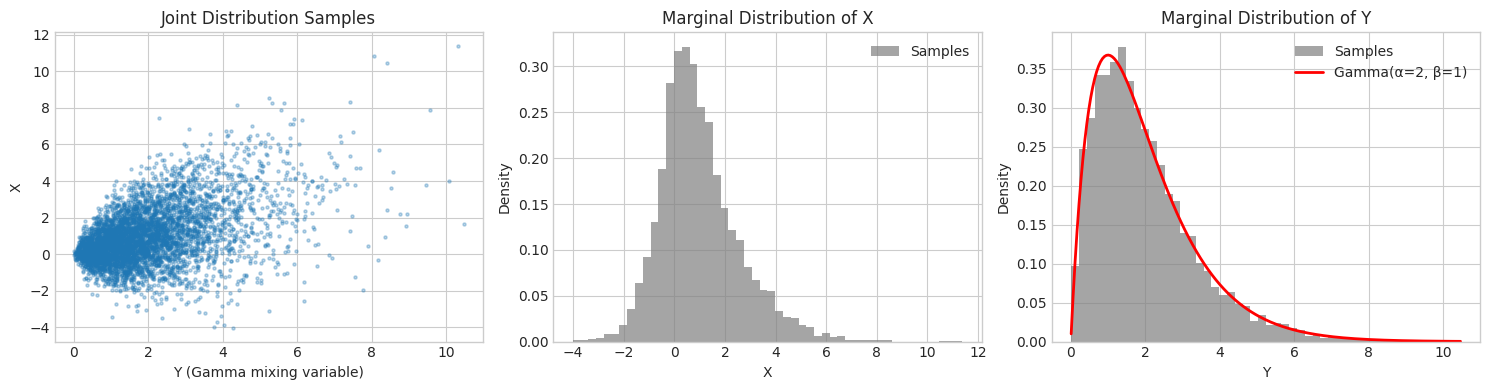

In [5]:
# Visualize joint samples
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Joint scatter plot
axes[0].scatter(Y_joint, X_joint.flatten(), alpha=0.3, s=5)
axes[0].set_xlabel('Y (Gamma mixing variable)')
axes[0].set_ylabel('X')
axes[0].set_title('Joint Distribution Samples')

# Marginal of X
axes[1].hist(X_joint.flatten(), bins=50, density=True, alpha=0.7, color=SAMPLE_COLOR, label='Samples')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')
axes[1].set_title('Marginal Distribution of X')
axes[1].legend()

# Marginal of Y (should be Gamma)
y_range = np.linspace(0.01, Y_joint.max(), 200)
gamma_pdf = stats.gamma.pdf(y_range, a=2.0, scale=1.0)  # shape=2, rate=1 -> scale=1
axes[2].hist(Y_joint, bins=50, density=True, alpha=0.7, color=SAMPLE_COLOR, label='Samples')
axes[2].plot(y_range, gamma_pdf, 'r-', linewidth=2, label='Gamma(α=2, β=1)')
axes[2].set_xlabel('Y')
axes[2].set_ylabel('Density')
axes[2].set_title('Marginal Distribution of Y')
axes[2].legend()

plt.tight_layout()
plt.show()

### 2.2 Marginal Distribution Sampling

For the marginal distribution, we only get $X$ values (Y is integrated out).

In [6]:
# Sample from marginal distribution (2D case)
X_marginal = vg_2d.rvs(size=n_samples, random_state=42)

print(f"X shape: {X_marginal.shape}")
print(f"\nSample statistics:")
print(f"  E[X] sample: {np.mean(X_marginal, axis=0)}")
print(f"  E[X] theory: {vg_2d.mean()}")
print(f"\n  Var[X] sample: {np.var(X_marginal, axis=0)}")
print(f"  Var[X] theory: {vg_2d.var()}")

X shape: (5000, 2)

Sample statistics:
  E[X] sample: [ 0.96279651 -0.63214703]
  E[X] theory: [ 1.  -0.6]

  Var[X] sample: [2.538617   2.21890888]
  Var[X] theory: [2.5  2.18]


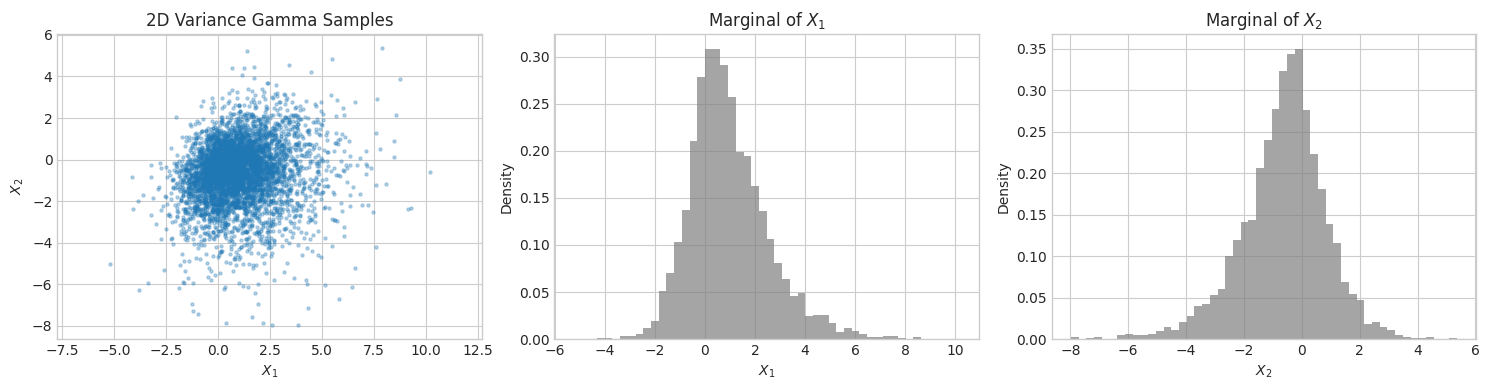

In [7]:
# Visualize 2D marginal distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Joint scatter of X1, X2
axes[0].scatter(X_marginal[:, 0], X_marginal[:, 1], alpha=0.3, s=5)
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('2D Variance Gamma Samples')
axes[0].axis('equal')

# Marginal of X1
axes[1].hist(X_marginal[:, 0], bins=50, density=True, alpha=0.7, color=SAMPLE_COLOR)
axes[1].set_xlabel('$X_1$')
axes[1].set_ylabel('Density')
axes[1].set_title('Marginal of $X_1$')

# Marginal of X2
axes[2].hist(X_marginal[:, 1], bins=50, density=True, alpha=0.7, color=SAMPLE_COLOR)
axes[2].set_xlabel('$X_2$')
axes[2].set_ylabel('Density')
axes[2].set_title('Marginal of $X_2$')

plt.tight_layout()
plt.show()

## 3. Effect of Parameters

### 3.1 Effect of Skewness Parameter $\gamma$

The $\gamma$ parameter controls the skewness of the distribution.

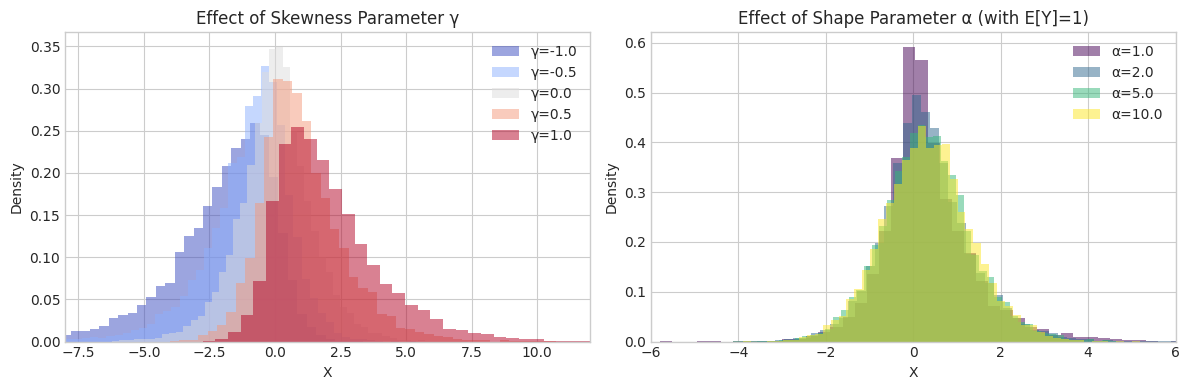

In [8]:
# Effect of gamma (skewness)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

gammas = [-1.0, -0.5, 0.0, 0.5, 1.0]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(gammas)))

for gamma_val, color in zip(gammas, colors):
    vg = VarianceGamma.from_classical_params(
        mu=np.array([0.0]),
        gamma=np.array([gamma_val]),
        sigma=np.array([[1.0]]),
        shape=2.0,
        rate=1.0
    )
    
    # Sample and plot histogram
    samples = vg.rvs(size=10000, random_state=42)
    axes[0].hist(samples, bins=50, density=True, alpha=0.5, color=color, label=f'γ={gamma_val}')

axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')
axes[0].set_title('Effect of Skewness Parameter γ')
axes[0].legend()
axes[0].set_xlim(-8, 12)

# Effect of shape parameter α
alphas = [1.0, 2.0, 5.0, 10.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

for alpha_val, color in zip(alphas, colors):
    vg = VarianceGamma.from_classical_params(
        mu=np.array([0.0]),
        gamma=np.array([0.3]),
        sigma=np.array([[1.0]]),
        shape=alpha_val,
        rate=alpha_val  # Keep E[Y]=1 constant
    )
    
    samples = vg.rvs(size=10000, random_state=42)
    axes[1].hist(samples, bins=50, density=True, alpha=0.5, color=color, label=f'α={alpha_val}')

axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')
axes[1].set_title('Effect of Shape Parameter α (with E[Y]=1)')
axes[1].legend()
axes[1].set_xlim(-6, 6)

plt.tight_layout()
plt.show()

## 4. Marginal PDF Validation

The marginal PDF involves the modified Bessel function $K_\nu(z)$. Let's validate by comparing histogram to the computed PDF.

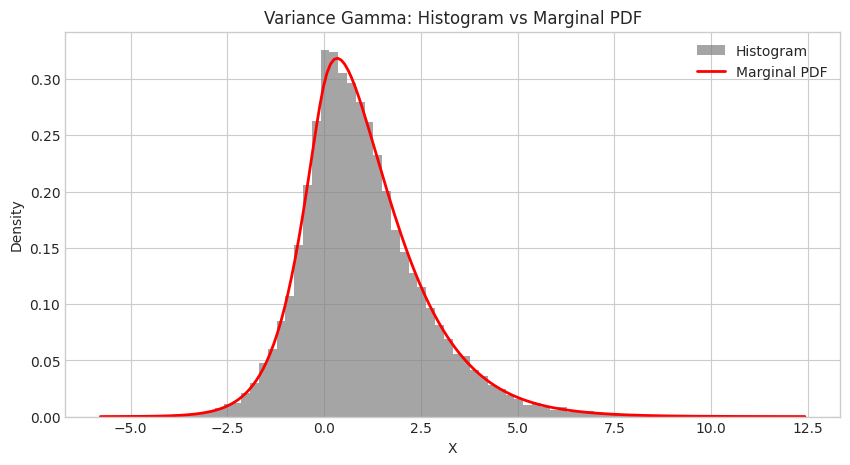

Sample mean: 0.9872, Theoretical: 1.0000
Sample var:  2.4981, Theoretical: 2.5000


In [9]:
# Create 1D VG for PDF validation
vg_1d = VarianceGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([0.5]),
    sigma=np.array([[1.0]]),
    shape=2.0,
    rate=1.0
)

# Generate samples
samples = vg_1d.rvs(size=20000, random_state=42)

# Compute PDF on a grid
x_grid = np.linspace(samples.min(), samples.max(), 200)
pdf_values = np.array([vg_1d.pdf(np.array([xi])) for xi in x_grid])

# Plot
plt.figure(figsize=(10, 5))
plt.hist(samples.flatten(), bins=80, density=True, alpha=0.7, color=SAMPLE_COLOR, label='Histogram')
plt.plot(x_grid, pdf_values, 'r-', linewidth=2, label='Marginal PDF')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Variance Gamma: Histogram vs Marginal PDF')
plt.legend()
plt.show()

print(f"Sample mean: {np.mean(samples):.4f}, Theoretical: {vg_1d.mean()[0]:.4f}")
print(f"Sample var:  {np.var(samples):.4f}, Theoretical: {vg_1d.var()[0]:.4f}")

## 5. Exponential Family Properties (Joint Distribution)

The joint distribution $f(x, y)$ is an exponential family with:

**Sufficient Statistics:**
$$t(x, y) = [\log y, y^{-1}, y, x, xy^{-1}, xx^T y^{-1}]$$

**Natural Parameters:**
$$\theta = [\alpha - 1 - d/2, -\frac{1}{2}\mu^T\Sigma^{-1}\mu, -(\beta + \frac{1}{2}\gamma^T\Sigma^{-1}\gamma), \Sigma^{-1}\gamma, \Sigma^{-1}\mu, -\frac{1}{2}\Sigma^{-1}]$$

In [10]:
# Show exponential family properties for joint distribution
jvg = JointVarianceGamma.from_classical_params(
    mu=np.array([1.0]),
    gamma=np.array([0.5]),
    sigma=np.array([[2.0]]),
    shape=3.0,
    rate=1.5
)

print("Classical Parameters:")
for key, val in jvg.get_classical_params().items():
    print(f"  {key}: {val}")

print(f"\nNatural Parameters: {jvg.get_natural_params()}")
print(f"\nExpectation Parameters: {jvg.get_expectation_params()}")

Classical Parameters:
  mu: [1.]
  gamma: [0.5]
  sigma: [[2.]]
  shape: 3.0
  rate: 1.5

Natural Parameters: [ 1.5    -0.25   -1.5625  0.25    0.5    -0.25  ]

Expectation Parameters: [0.51731923 0.75       2.         2.         1.25       4.25      ]


In [11]:
# Verify E[t(X,Y)] matches expectation parameters
n_samples = 50000
X, Y = jvg.rvs(size=n_samples, random_state=42)

# Compute sufficient statistics
t_samples = jvg._sufficient_statistics(X, Y)

# Sample mean of sufficient statistics
eta_sample = np.mean(t_samples, axis=0)

# Theoretical expectation parameters
eta_theory = jvg.get_expectation_params()

print("Verification: E[t(X,Y)] ≈ η (expectation parameters)")
print("\nComponent | Sample Mean | Theory")
print("-" * 45)
names = ['E[log Y]', 'E[1/Y]', 'E[Y]', 'E[X]', 'E[X/Y]', 'E[XX/Y]']
for i, (s, t) in enumerate(zip(eta_sample, eta_theory)):
    name = names[min(i, len(names)-1)]
    if np.isfinite(t):
        print(f"{name:10s} | {s:11.4f} | {t:.4f}")
    else:
        print(f"{name:10s} | {s:11.4f} | inf")

Verification: E[t(X,Y)] ≈ η (expectation parameters)

Component | Sample Mean | Theory
---------------------------------------------
E[log Y]   |      0.5148 | 0.5173
E[1/Y]     |      0.7524 | 0.7500
E[Y]       |      1.9973 | 2.0000
E[X]       |      1.9992 | 2.0000
E[X/Y]     |      1.2472 | 1.2500
E[XX/Y]    |      4.2607 | 4.2500


## 6. Joint PDF Evaluation

The joint distribution provides closed-form PDF evaluation.

In [12]:
# Evaluate joint log PDF
X_test, Y_test = jvg.rvs(size=5, random_state=123)

log_pdf = jvg.logpdf(X_test, Y_test)
pdf = jvg.pdf(X_test, Y_test)

print("Joint PDF evaluation:")
print(f"X = {X_test.flatten()}")
print(f"Y = {Y_test}")
print(f"log f(X,Y) = {log_pdf}")
print(f"f(X,Y) = {pdf}")

Joint PDF evaluation:
X = [ 1.58250435 -1.29316816  5.40001792  0.55849187  3.43373014]
Y = [0.90374022 3.58080688 2.97956447 1.17100467 1.45490642]
log f(X,Y) = [-2.25441504 -5.36432387 -4.28457499 -2.48715855 -2.86248069]
f(X,Y) = [0.10493491 0.00468062 0.01377948 0.08314589 0.05712687]


## 7. Accessing Joint from Marginal

The `VarianceGamma` marginal class provides access to the underlying `JointVarianceGamma` via the `.joint` property.

In [13]:
# Create marginal distribution
vg = VarianceGamma.from_classical_params(
    mu=np.array([0.0, 1.0]),
    gamma=np.array([0.5, -0.3]),
    sigma=np.array([[1.0, 0.2], [0.2, 1.5]]),
    shape=2.5,
    rate=1.0
)

# Marginal methods
print("Marginal distribution methods:")
print(f"  vg.pdf(x) - returns marginal PDF")
print(f"  vg.rvs(size) - returns X samples only")
print(f"  vg.mean() = {vg.mean()}")

# Joint methods via .joint property
print("\nJoint distribution methods (via .joint):")
print(f"  vg.joint.pdf(x, y) - returns joint PDF")
print(f"  vg.joint.rvs(size) - returns (X, Y) tuple")
print(f"  vg.joint.get_natural_params() = {vg.joint.get_natural_params()[:3]}...")

# Convenience methods
print("\nConvenience aliases:")
print(f"  vg.pdf_joint(x, y) ≡ vg.joint.pdf(x, y)")
print(f"  vg.rvs_joint(size) ≡ vg.joint.rvs(size)")

Marginal distribution methods:
  vg.pdf(x) - returns marginal PDF
  vg.rvs(size) - returns X samples only
  vg.mean() = [1.25 0.25]

Joint distribution methods (via .joint):
  vg.joint.pdf(x, y) - returns joint PDF
  vg.joint.rvs(size) - returns (X, Y) tuple
  vg.joint.get_natural_params() = [ 0.5        -0.34246575 -1.17979452]...

Convenience aliases:
  vg.pdf_joint(x, y) ≡ vg.joint.pdf(x, y)
  vg.rvs_joint(size) ≡ vg.joint.rvs(size)


In [14]:
# Demonstrate both sampling methods
print("Sampling comparison:")

# Marginal sampling (X only)
X_marginal = vg.rvs(size=3, random_state=42)
print(f"\nvg.rvs(size=3) returns X only:")
print(f"  Shape: {X_marginal.shape}")
print(f"  Values:\n{X_marginal}")

# Joint sampling (X and Y)
X_joint, Y_joint = vg.rvs_joint(size=3, random_state=42)
print(f"\nvg.rvs_joint(size=3) returns (X, Y):")
print(f"  X shape: {X_joint.shape}, Y shape: {Y_joint.shape}")
print(f"  X values:\n{X_joint}")
print(f"  Y values: {Y_joint}")

Sampling comparison:

vg.rvs(size=3) returns X only:
  Shape: (3, 2)
  Values:
[[ 0.04926877  0.61659615]
 [ 3.73254507  1.43354251]
 [ 2.79808186 -0.14092394]]

vg.rvs_joint(size=3) returns (X, Y):
  X shape: (3, 2), Y shape: (3,)
  X values:
[[ 0.04926877  0.61659615]
 [ 3.73254507  1.43354251]
 [ 2.79808186 -0.14092394]]
  Y values: [2.64686082 3.46966085 2.36034294]


## 8. Special Case: Symmetric Distribution ($\gamma = 0$)

When $\gamma = 0$, the VG distribution is symmetric around $\mu$.

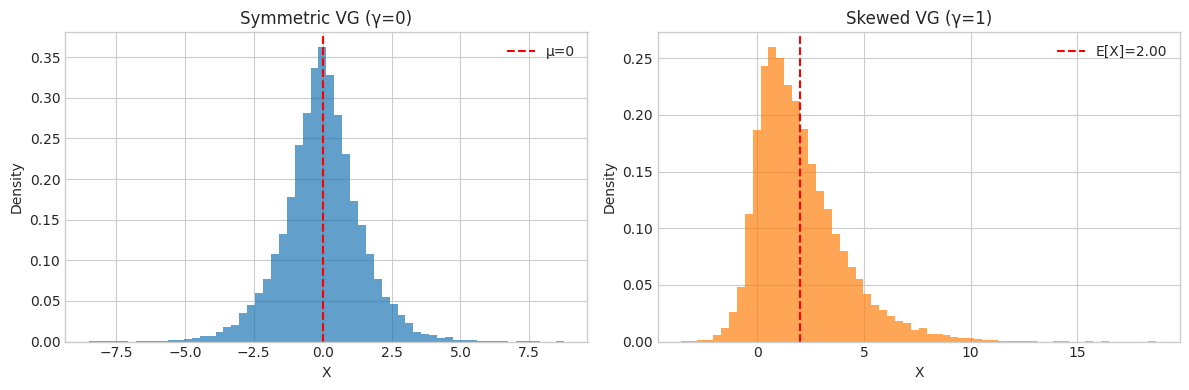

Symmetric VG: mean=-0.0193, skewness≈-0.0140
Skewed VG:    mean=1.9938, skewness≈1.2588


In [15]:
# Symmetric VG (gamma = 0)
vg_symmetric = VarianceGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([0.0]),
    sigma=np.array([[1.0]]),
    shape=2.0,
    rate=1.0
)

# Asymmetric VG for comparison
vg_skewed = VarianceGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([1.0]),
    sigma=np.array([[1.0]]),
    shape=2.0,
    rate=1.0
)

# Sample and compare
samples_sym = vg_symmetric.rvs(size=20000, random_state=42)
samples_skew = vg_skewed.rvs(size=20000, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(samples_sym.flatten(), bins=60, density=True, alpha=0.7, color=PYGH_COLOR)
axes[0].axvline(0, color='red', linestyle='--', label='μ=0')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')
axes[0].set_title('Symmetric VG (γ=0)')
axes[0].legend()

axes[1].hist(samples_skew.flatten(), bins=60, density=True, alpha=0.7, color='tab:orange')
axes[1].axvline(vg_skewed.mean()[0], color='red', linestyle='--', label=f'E[X]={vg_skewed.mean()[0]:.2f}')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')
axes[1].set_title('Skewed VG (γ=1)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Symmetric VG: mean={np.mean(samples_sym):.4f}, skewness≈{stats.skew(samples_sym.flatten()):.4f}")
print(f"Skewed VG:    mean={np.mean(samples_skew):.4f}, skewness≈{stats.skew(samples_skew.flatten()):.4f}")

## 9. Comparison with Normal Distribution

VG has heavier tails than the normal distribution. As $\alpha \to \infty$ (with $\beta$ scaled), VG converges to normal.

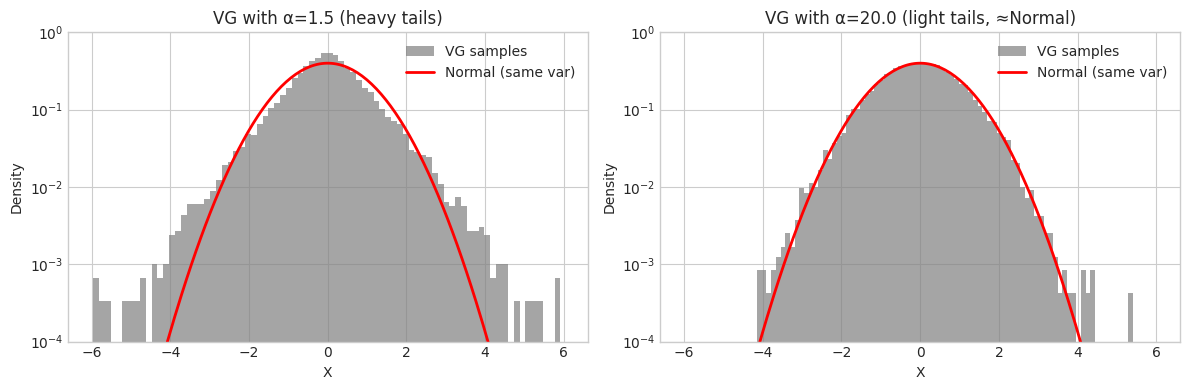

VG(α=1.5) kurtosis: 1.99 (Normal=0)
VG(α=20)  kurtosis: 0.27 (Normal=0)


In [16]:
# Compare VG tails with Normal
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Small α (heavy tails)
vg_heavy = VarianceGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([0.0]),
    sigma=np.array([[1.0]]),
    shape=1.5,  # Small α
    rate=1.5    # E[Y] = 1
)

# Large α (closer to normal)
vg_light = VarianceGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([0.0]),
    sigma=np.array([[1.0]]),
    shape=20.0,  # Large α
    rate=20.0    # E[Y] = 1
)

samples_heavy = vg_heavy.rvs(size=20000, random_state=42)
samples_light = vg_light.rvs(size=20000, random_state=42)

# Normal with same variance
var_heavy = vg_heavy.var()[0]
var_light = vg_light.var()[0]

x_range = np.linspace(-6, 6, 200)

axes[0].hist(samples_heavy.flatten(), bins=80, density=True, alpha=0.7, color=SAMPLE_COLOR, label='VG samples')
axes[0].plot(x_range, stats.norm.pdf(x_range, scale=np.sqrt(var_heavy)), 'r-', linewidth=2, label='Normal (same var)')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')
axes[0].set_title(f'VG with α={1.5} (heavy tails)')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-4, 1)

axes[1].hist(samples_light.flatten(), bins=80, density=True, alpha=0.7, color=SAMPLE_COLOR, label='VG samples')
axes[1].plot(x_range, stats.norm.pdf(x_range, scale=np.sqrt(var_light)), 'r-', linewidth=2, label='Normal (same var)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')
axes[1].set_title(f'VG with α={20.0} (light tails, ≈Normal)')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-4, 1)

plt.tight_layout()
plt.show()

print(f"VG(α=1.5) kurtosis: {stats.kurtosis(samples_heavy.flatten()):.2f} (Normal=0)")
print(f"VG(α=20)  kurtosis: {stats.kurtosis(samples_light.flatten()):.2f} (Normal=0)")

## Summary

The Variance Gamma distribution provides:

1. **Heavy tails** controlled by the Gamma shape parameter $\alpha$
2. **Skewness** controlled by the $\gamma$ parameter
3. **Joint distribution** $f(x,y)$ is an exponential family with closed-form sufficient statistics
4. **Marginal distribution** $f(x)$ has closed-form PDF involving Bessel functions
5. **Parameter estimation**:
   - **Complete data** $(X, Y)$: Closed-form MLE via exponential family
   - **Marginal data** $(X)$: EM algorithm with GIG conditional distribution

The `VarianceGamma` class provides the familiar API for the marginal distribution, with access to the joint distribution via `.joint` for exponential family methods (natural parameters, etc.).

### Key Methods

| Method | Description |
|--------|-------------|
| `VarianceGamma.fit(X)` | Fit using EM algorithm (marginal data) |
| `VarianceGamma.fit_complete(X, Y)` | Fit using MLE (complete data) |
| `JointVarianceGamma.fit(X, Y)` | Fit joint distribution (exponential family MLE) |

## 10. Parameter Estimation

### 10.1 Complete Data Fitting (Joint Distribution)

When both $X$ and $Y$ are observed, the joint distribution is an exponential family, so MLE has a closed-form solution via the sample mean of sufficient statistics.

In [17]:
# Complete data fitting example
np.random.seed(42)

# True parameters
true_params = {
    'mu': np.array([0.5]),
    'gamma': np.array([0.3]),
    'sigma': np.array([[1.2]]),
    'shape': 2.5,
    'rate': 1.0
}

# Create true distribution and generate complete data
true_joint = JointVarianceGamma.from_classical_params(**true_params)
X_complete, Y_complete = true_joint.rvs(size=5000, random_state=42)

# Fit using complete data
fitted_joint = JointVarianceGamma(d=1).fit(X_complete, Y_complete)

print("Complete Data Fitting Results:")
print("=" * 50)
print(f"{'Parameter':<15} {'True':>12} {'Fitted':>12}")
print("-" * 50)

true_p = true_joint.get_classical_params()
fitted_p = fitted_joint.get_classical_params()

print(f"{'μ':<15} {true_p['mu'][0]:>12.4f} {fitted_p['mu'][0]:>12.4f}")
print(f"{'γ':<15} {true_p['gamma'][0]:>12.4f} {fitted_p['gamma'][0]:>12.4f}")
print(f"{'Σ':<15} {true_p['sigma'][0,0]:>12.4f} {fitted_p['sigma'][0,0]:>12.4f}")
print(f"{'α (shape)':<15} {true_p['shape']:>12.4f} {fitted_p['shape']:>12.4f}")
print(f"{'β (rate)':<15} {true_p['rate']:>12.4f} {fitted_p['rate']:>12.4f}")
print("-" * 50)
print(f"{'E[X]':<15} {true_joint.mean()[0][0]:>12.4f} {fitted_joint.mean()[0][0]:>12.4f}")
print(f"{'E[Y]':<15} {true_joint.mean()[1]:>12.4f} {fitted_joint.mean()[1]:>12.4f}")

Complete Data Fitting Results:
Parameter               True       Fitted
--------------------------------------------------
μ                     0.5000       0.5140
γ                     0.3000       0.2869
Σ                     1.2000       1.1995
α (shape)             2.5000       2.5265
β (rate)              1.0000       1.0080
--------------------------------------------------
E[X]                  1.2500       1.2330
E[Y]                  2.5000       2.5063


### 10.2 Marginal Data Fitting (EM Algorithm)

When only $X$ is observed (the mixing variable $Y$ is latent), we use the EM algorithm:

**E-step**: Compute conditional expectations $E[Y|X]$, $E[1/Y|X]$, $E[\log Y|X]$ using the GIG conditional distribution

**M-step**: Update parameters using closed-form solutions for $(\mu, \gamma, \Sigma)$ and Newton's method for $(\alpha, \beta)$

In [18]:
# EM algorithm fitting (marginal data only)
np.random.seed(42)

# True parameters
true_params = {
    'mu': np.array([0.0]),
    'gamma': np.array([0.5]),
    'sigma': np.array([[1.0]]),
    'shape': 2.0,
    'rate': 1.0
}

# Create true distribution and generate marginal data (X only)
true_vg = VarianceGamma.from_classical_params(**true_params)
X_marginal = true_vg.rvs(size=5000, random_state=42)

# Fit using EM algorithm
fitted_vg = VarianceGamma().fit(X_marginal, max_iter=100, tol=1e-6, verbose=1)

print("\n" + "=" * 50)
print("EM Fitting Results:")
print("=" * 50)
print(f"{'Parameter':<15} {'True':>12} {'Fitted':>12}")
print("-" * 50)

true_p = true_vg.get_classical_params()
fitted_p = fitted_vg.get_classical_params()

print(f"{'μ':<15} {true_p['mu'][0]:>12.4f} {fitted_p['mu'][0]:>12.4f}")
print(f"{'γ':<15} {true_p['gamma'][0]:>12.4f} {fitted_p['gamma'][0]:>12.4f}")
print(f"{'Σ':<15} {true_p['sigma'][0,0]:>12.4f} {fitted_p['sigma'][0,0]:>12.4f}")
print(f"{'α (shape)':<15} {true_p['shape']:>12.4f} {fitted_p['shape']:>12.4f}")
print(f"{'β (rate)':<15} {true_p['rate']:>12.4f} {fitted_p['rate']:>12.4f}")
print("-" * 50)
print(f"{'E[X]':<15} {true_vg.mean()[0]:>12.4f} {fitted_vg.mean()[0]:>12.4f}")
print(f"{'Var[X]':<15} {true_vg.var()[0]:>12.4f} {fitted_vg.var()[0]:>12.4f}")

Initial log-likelihood: -1.840059
Converged at iteration 42
Final log-likelihood: -1.815236

EM Fitting Results:
Parameter               True       Fitted
--------------------------------------------------
μ                     0.0000      -0.0076
γ                     0.5000       0.5226
Σ                     1.0000       1.0304
α (shape)             2.0000       1.8225
β (rate)              1.0000       0.9464
--------------------------------------------------
E[X]                  1.0000       0.9988
Var[X]                2.5000       2.5400


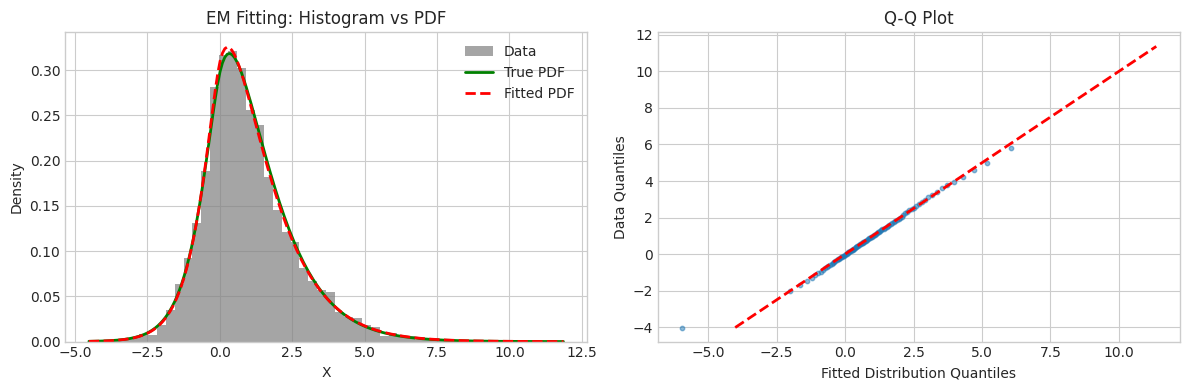

In [19]:
# Visualize the fitted distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram vs fitted PDF
x_range = np.linspace(X_marginal.min() - 0.5, X_marginal.max() + 0.5, 200)

axes[0].hist(X_marginal.flatten(), bins=50, density=True, alpha=0.7, color=SAMPLE_COLOR, label='Data')
axes[0].plot(x_range, true_vg.pdf(x_range.reshape(-1, 1)), 'g-', linewidth=2, label='True PDF')
axes[0].plot(x_range, fitted_vg.pdf(x_range.reshape(-1, 1)), 'r--', linewidth=2, label='Fitted PDF')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')
axes[0].set_title('EM Fitting: Histogram vs PDF')
axes[0].legend()

# Q-Q plot
from scipy.stats import probplot

# Generate samples from fitted distribution
fitted_samples = fitted_vg.rvs(size=len(X_marginal), random_state=123)

# Sort both
data_sorted = np.sort(X_marginal.flatten())
fitted_sorted = np.sort(fitted_samples.flatten())

axes[1].scatter(fitted_sorted[::50], data_sorted[::50], alpha=0.5, s=10)
axes[1].plot([data_sorted.min(), data_sorted.max()], [data_sorted.min(), data_sorted.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Fitted Distribution Quantiles')
axes[1].set_ylabel('Data Quantiles')
axes[1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

### 10.3 2D Fitting Example

The EM algorithm also works for multivariate data.

In [20]:
# 2D EM fitting
np.random.seed(42)

# True 2D parameters
true_params_2d = {
    'mu': np.array([1.0, -0.5]),
    'gamma': np.array([0.3, 0.2]),
    'sigma': np.array([[1.0, 0.3], [0.3, 0.8]]),
    'shape': 2.5,
    'rate': 1.0
}

# Generate data
true_vg_2d = VarianceGamma.from_classical_params(**true_params_2d)
X_2d = true_vg_2d.rvs(size=5000, random_state=42)

# Fit
fitted_vg_2d = VarianceGamma().fit(X_2d, max_iter=100, tol=1e-6, verbose=0)

# Compare
print("2D EM Fitting Results:")
print("=" * 60)

true_p = true_vg_2d.get_classical_params()
fitted_p = fitted_vg_2d.get_classical_params()

print(f"True μ:    {true_p['mu']}")
print(f"Fitted μ:  {fitted_p['mu']}")
print()
print(f"True γ:    {true_p['gamma']}")
print(f"Fitted γ:  {fitted_p['gamma']}")
print()
print(f"True Σ:\n{true_p['sigma']}")
print(f"Fitted Σ:\n{fitted_p['sigma']}")
print()
print(f"True (α, β):    ({true_p['shape']:.4f}, {true_p['rate']:.4f})")
print(f"Fitted (α, β):  ({fitted_p['shape']:.4f}, {fitted_p['rate']:.4f})")
print()
print(f"True E[X]:   {true_vg_2d.mean()}")
print(f"Fitted E[X]: {fitted_vg_2d.mean()}")

2D EM Fitting Results:
True μ:    [ 1.  -0.5]
Fitted μ:  [ 0.98502489 -0.46420247]

True γ:    [0.3 0.2]
Fitted γ:  [0.37036707 0.24604625]

True Σ:
[[1.  0.3]
 [0.3 0.8]]
Fitted Σ:
[[1.29320468 0.38092306]
 [0.38092306 1.0222868 ]]

True (α, β):    (2.5000, 1.0000)
Fitted (α, β):  (2.5134, 1.2703)

True E[X]:   [1.75000000e+00 2.77555756e-16]
Fitted E[X]: [1.71782   0.0226159]


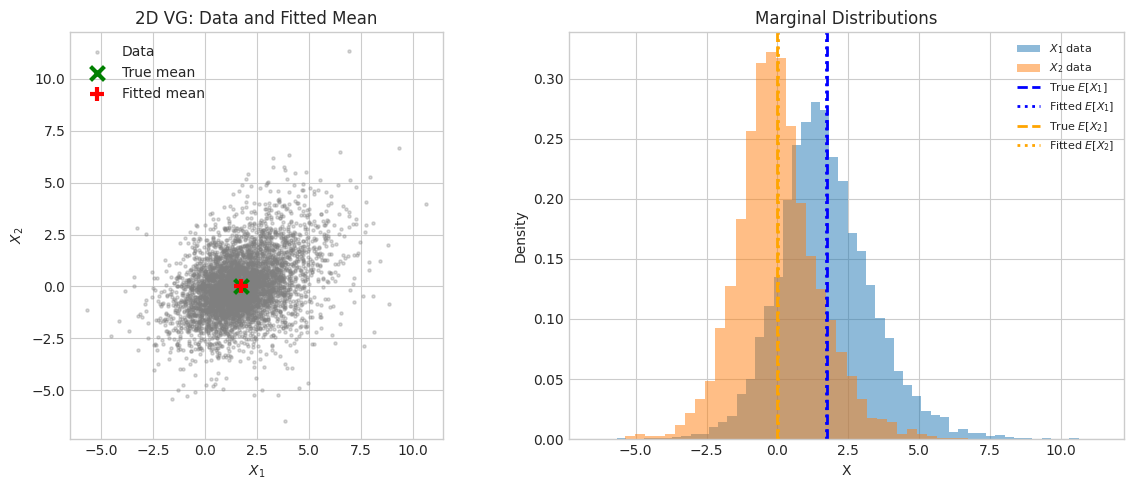

In [21]:
# Visualize 2D fitting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of data
axes[0].scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.3, s=5, c=SAMPLE_COLOR, label='Data')
axes[0].scatter(*true_vg_2d.mean(), c='green', s=100, marker='x', linewidths=3, label='True mean')
axes[0].scatter(*fitted_vg_2d.mean(), c='red', s=100, marker='+', linewidths=3, label='Fitted mean')
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('2D VG: Data and Fitted Mean')
axes[0].legend()
axes[0].set_aspect('equal')

# Marginal histograms comparison
axes[1].hist(X_2d[:, 0], bins=50, density=True, alpha=0.5, color='tab:blue', label='$X_1$ data')
axes[1].hist(X_2d[:, 1], bins=50, density=True, alpha=0.5, color='tab:orange', label='$X_2$ data')
axes[1].axvline(true_vg_2d.mean()[0], color='blue', linestyle='--', linewidth=2, label=f'True $E[X_1]$')
axes[1].axvline(fitted_vg_2d.mean()[0], color='blue', linestyle=':', linewidth=2, label=f'Fitted $E[X_1]$')
axes[1].axvline(true_vg_2d.mean()[1], color='orange', linestyle='--', linewidth=2, label=f'True $E[X_2]$')
axes[1].axvline(fitted_vg_2d.mean()[1], color='orange', linestyle=':', linewidth=2, label=f'Fitted $E[X_2]$')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')
axes[1].set_title('Marginal Distributions')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()